Transformer is a continuation of sequential models like RNN that is meant to tackle the problem of data being fed to the network sequentially. It also shows great capabilties when it comes to capturing patterns in a very early data, since it looks at a sequence as a whole instead of looking through it partially like LSTM or aforesaid RNN.

The model consists of many blocks, primarly Encoder and Decoder blocks. The first one is used to encode sequences of tokens and learn representations of text along the training loop, whereas the second one is used to decode encoded sequences and predict another sequence based on the input embedding. Hence the first block is highly applicable in problems for transforming text features to vectors and the second - in generative problems. This notebook is going to be dedicated to the **implementation of the Encoder** utilizing multihead self attention:

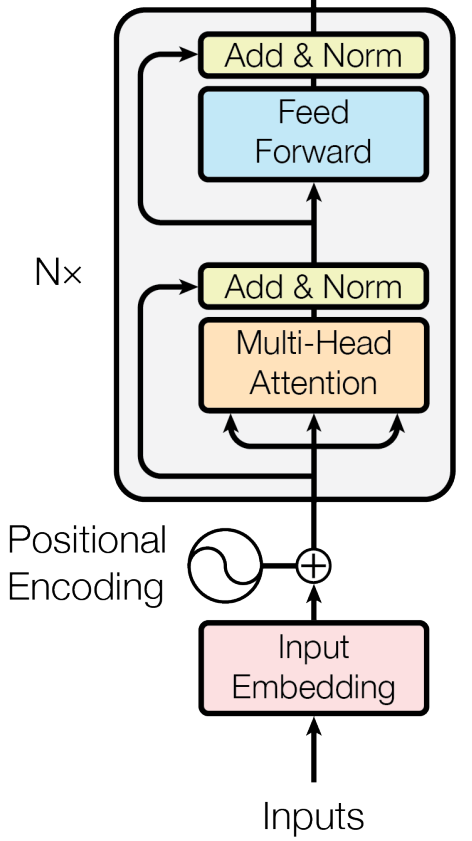
###### Fig.1. Transformer architecture

#### Creating embeddings layer
Instead of sinusoidal positional encodings as proposed in the paper we can use learnable positional embeddings:

In [105]:
import torch
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class posEmbed(nn.Module):
    
    def __init__(self, v, d, max_length, dropout=.01):
        """
        - v: int
            - vocab size
        - d: int
            - embeddings dims
        - max_length: int
            - maximum sentence length used for pos embeddings
        - dropout: float
            - dropout rate (fraction of neurons that must be randomly zeroed out)
        """
        super().__init__()
        
        # building embedding layers that expect indices 
        # in the forward method below
        self.token_embed = nn.Embedding(v, d)
        self.pos_embed = nn.Embedding(max_length, d)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_len = x.shape
        pos = torch.arange(0, seq_len).expand(
            batch_size, seq_len
        ).to(device)
        emb = self.token_embed(x) + self.pos_embed(pos)
        return self.dropout(emb)

#### Creating Multi-Head self-Attention layer
To see what's the difference between regular self-attention layer and the multi-head one we can refer to this diagram:
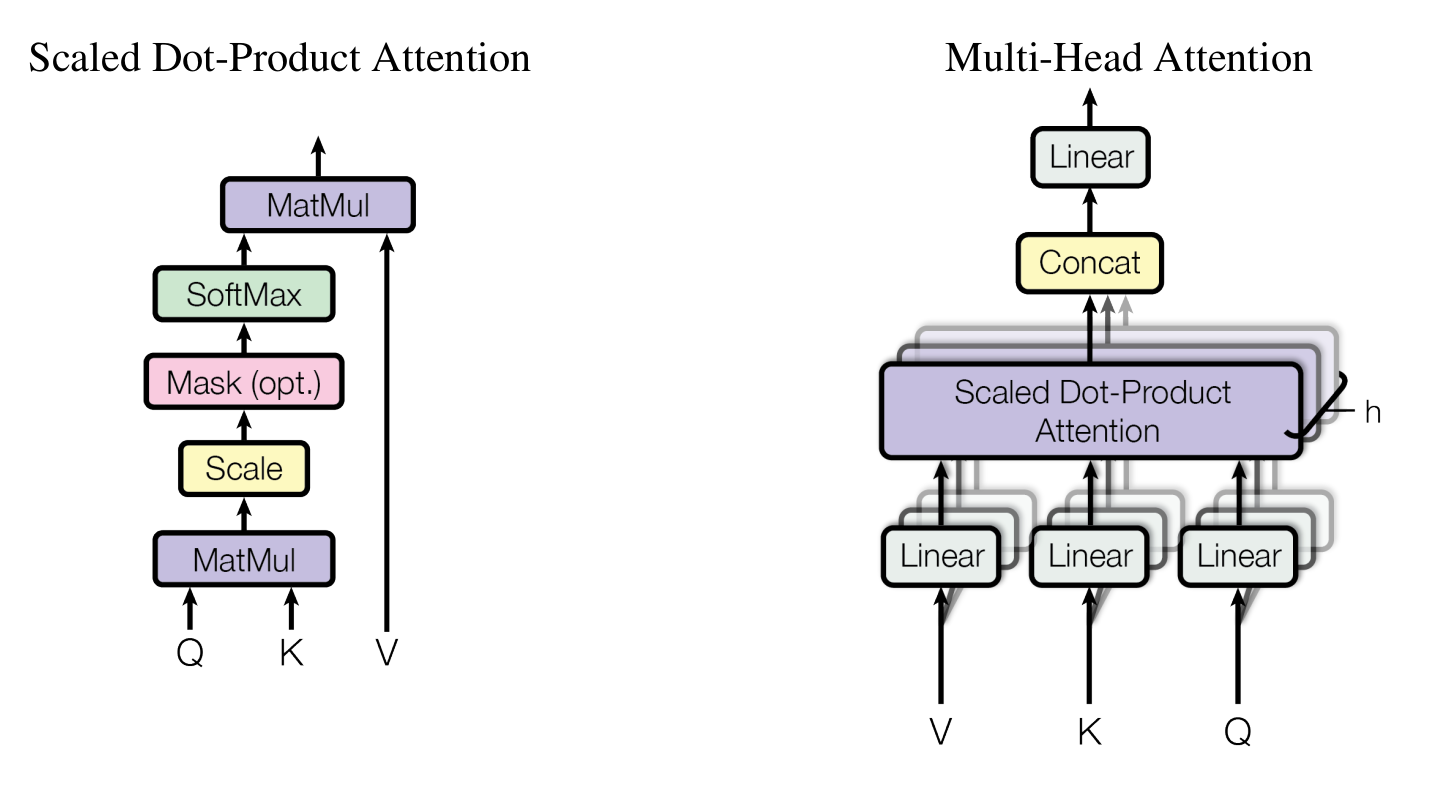
###### Fig.2. Difference between dot-product attention and MH attention

#### Proprietary brush-up
You can skip this section if you are familiar with `einsum` API in pytorch, however I feel like it's always nice to have a brush-up on this method, which for some reason one might not see frequently in open-source, although it allowing very useful and interpretable interface for matrix manipulations beween $A$ and $B$ arbitrary matrices. Here's a recap on most applicable operations, more can be seen here: https://stackoverflow.com/questions/55894693/understanding-pytorch-einsum

* Matrix multiplication
> `torch.einsum('ij, jk -> ik', A, B)`
* Extract elements along the main diagonal
> `torch.einsum('ii -> i', A)`
* Hadamard product $[A\odot B]$ (element-wise product between two matrices)
> `torch.einsum('ij, ij -> ij', A, B)`
* Transpose matrix
> `torch.einsum('ij -> ji', A)`
* Outer Product $[A\otimes B = AB^T]$
> `torch.einsum('i, j -> ij', A, B)`
* Inner product $[\langle A,B \rangle = A^TB]$ (opposite of outer product. Instead of matrix yields a scalar). In Euclidean space inner product is often used interchargeably with the dot product
> `torch.einsum('i, i -> ', A, B)`
* Sum along axes $0$ (`j`) or $1$ (`i`)
> `torch.einsum('ij -> j', A)` or `i`
* Sum along axis 2 in 3d tensors
> `torch.einsum('ijk -> ij', A)`
* Batch matrix multiplication
> `torch.einsum('bij, bjk -> bik', A, B)`
* Frobenius inner product $[\langle A,B \rangle _F]$ (element-wise multiplication and sum over them). Also applicable to complex numbers (if they're in matrix $A$)
> `torch.einsum('ij, ij -> ', A, B)`

In [123]:
class mhSelfAttention(nn.Module):
    
    def __init__(self, d, n_heads):
        """ 
        - d: int
            - embedding dims
        - n_heads: int
            - number of self-attention layers (heads)
        """
        super().__init__()
        self.d = d
        self.n_heads = n_heads
        self.head_d = self.d // self.n_heads

        assert (self.n_heads*self.head_d == self.d), \
            'embed dims must be divisible by N heads'
        
        self.q_proj = nn.Linear(self.d, self.d, bias=False)
        self.v_proj = nn.Linear(self.d, self.d, bias=False)
        self.k_proj = nn.Linear(self.d, self.d, bias=False)

        self.fc_out = nn.Linear(self.n_heads * self.head_d, self.d)

    def forward(self, x):
        """ 
        - x: torch.Tensor
            - input tensor of shape [batch_size, seq_len, embed_dims]
        """

        batch_size, seq_len = x.shape[0], x.shape[1]

        # understanding linear projections combined with different
        # permutations can be tricky here. Thus, for visual reference
        # for the inner workings of them refer to the fig. 3 below
        Q = self.q_proj(x).reshape(
            batch_size, seq_len, self.n_heads,self.head_d).permute(
                0, 2, 1, 3
            )
        K = self.k_proj(x).reshape(
            batch_size, seq_len, self.n_heads,self.head_d).permute(
                0, 2, 3, 1
            )
        V = self.v_proj(x).reshape(
            batch_size, seq_len, self.n_heads,self.head_d).permute(
                0, 2, 1, 3
            )
        
        # making BMM via einsum API (see examples of einsum operations above)
        att_scores = torch.einsum('bijk,bikl -> bijl', Q, K)
        
        # transforming QK into probabilities with preliminary norm
        att_matrix = torch.softmax(att_scores/self.d**.5, dim=-1)
        att_out = torch.einsum('bijk,bikl -> bijl', att_matrix, V)

        # reverse transformation of multihead -> tensor of sequences of tokens
        concat_out = att_out.permute(0, 2, 1, 3).reshape(batch_size,seq_len,self.d)

        return concat_out

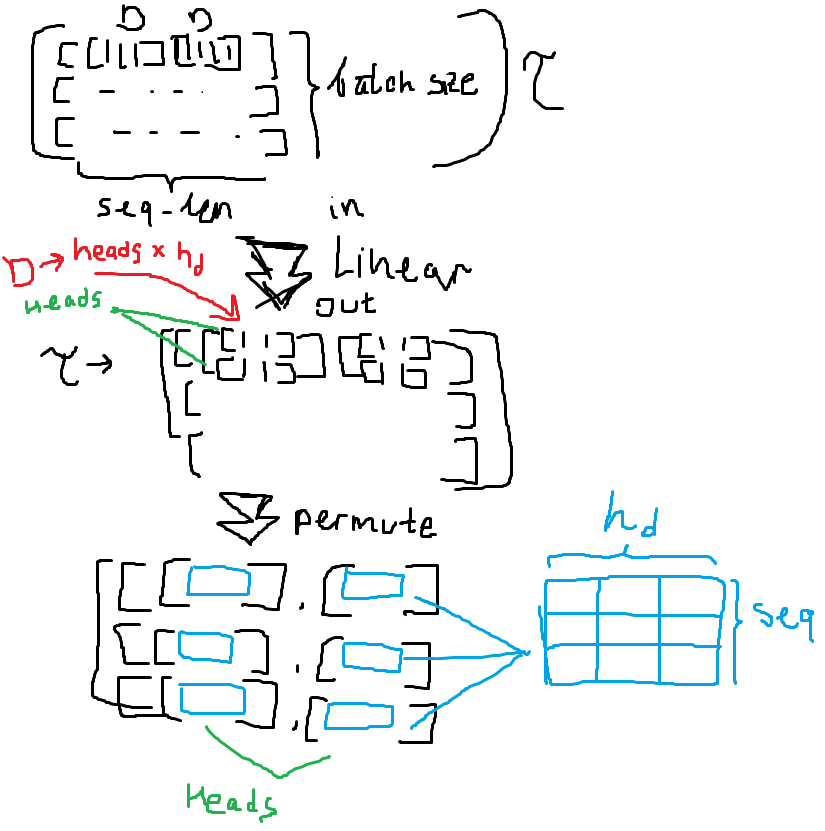
###### Fig.3. How do transformations in MH attentions relate to each other and what is their output? Visual description

#### Building Encoder block with MH attention

In [103]:
class TransformerEncoder(nn.Module):
    
    def __init__(self, d, n_heads, gamma=1, dropout=.1, *args, **kwargs) -> None:
        """ 
        - d: int
            - embedding dimensions
        - n_heads: int
            - number of heads in multihead attention
        - gamma: int
            - multiplier for number of neurons to be in hidden layers
         compared to the number of input ones
        - dropout: float
            - dropout rate (explained in previously defined encoding module)
        """
        super().__init__(*args, **kwargs)
        
        self.att = mhSelfAttention(d, n_heads)

        # simple normalization layers, that apply Z-score
        # normalization to weights with additional embed parameters of
        # gamma and beta: https://arxiv.org/pdf/1607.06450
        self.norm1 = nn.LayerNorm(d)
        self.norm2 = nn.LayerNorm(d)
        
        # instead of ReLU we could apply GELU that is incorporated in many
        # models' norm modules including Gemma: https://arxiv.org/pdf/2403.08295
        self.ffn = nn.Sequential(
            nn.Linear(d,d*gamma),
            nn.GELU(),
            nn.Linear(d*gamma,d)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        att_out = self.dropout(self.att(x))
        x = self.norm1(x + att_out)
        ffn_out = self.ffn(x)
        return self.norm2(x + ffn_out)

#### Building a classifier ontop of MH attention based Encoder

In [126]:
class attBinaryClassifier(nn.Module):

    def __init__(self, vocab_size, max_seq_len, embed_dims,
                 n_heads, gamma, dropout, *args, **kwargs) -> None:
        """ 
        - vocab_size: int
            - possible number of tokens
        - max_seq_len: int
            - maximum number of tokens (for pos. encoding)
        - embed_dims: int
            - embedding dimensions
        - n_heads: int
            - number of heads in MH attention
        - gamma: int
            - multiplier for number of neurons to be in hidden layers of 
            the encoder compared to the number of input ones
        - dropout: float
            - dropout rate (explained in previously defined encoding module)
            that is used for Encoder
        """

        super().__init__(*args, **kwargs)

        self.embedder = posEmbed(vocab_size, embed_dims, max_seq_len)
        self.encoder = TransformerEncoder(embed_dims, n_heads, gamma, dropout)
        self.fc = nn.Linear(embed_dims, 1)

    def forward(self, x):
        embeddings = self.embedder(x)
        encodings = self.encoder(embeddings)
        compact_encodings = encodings.max(dim=1)[0]
        return self.fc(compact_encodings)

#### Loading up data from the binary Stress Detection dataset
Pulling up data from kaggle, namely https://www.kaggle.com/datasets/mexwell/stress-detection-from-social-media-articles

In [1]:
!pip install kaggle-cli
!kaggle datasets download -d mexwell/stress-detection-from-social-media-articles

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 41.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.5 MB/s eta 0:00:00
  Created wheel for kaggle-cli: filename=kaggle_cli-0.12.13-py3-none-any.whl size=9468 sha256=1073d99d6cda097162ff5e8233c2f2dd58faee928713fd166ee20d0a9ec4d9ec
  Stored in directory: /root/.cache/pip/wheels/76/71/79/84b4614152023629f0019a6632e4dd14c4455d717114d7d6f7
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run su

In [47]:
import polars as pl
ds_path = '/kaggle/input/stress-detection-from-social-media-articles/Reddit_Combi.csv'
df = pl.read_csv(ds_path, truncate_ragged_lines=True,separator=';')
df.head(2)

title,body,Body_Title,label,
str,str,str,i64,str
"""Envy to other …","""Im from develo…","""Envy to other …",1,null
"""Nothin outta t…","""Um hello ....w…","""Nothin outta t…",1,null


#### Small data preprocessing
Getting text sequences as `X` and corresponding labels `y` with propreitary preprocessing, namely:
* dropping NaNs/nulls
* dropping empty posts
* dropping duplicated posts
* getting rid of links in posts

In [48]:
xFeature, yFeature = 'Body_Title', 'label'

# dropping NA's
df = df.with_columns(pl.col(xFeature).drop_nans())
df = df.with_columns(pl.col(yFeature).drop_nans())
df = df.with_columns(pl.col(xFeature).drop_nulls())
df = df.with_columns(pl.col(yFeature).drop_nulls())

# get rid of empty or extremely short posts
df = df.filter(~(pl.col(xFeature).str.len_chars() <= 1))

# get rid of duplicates
df = df.filter(~(pl.col(xFeature).is_duplicated()))

# removing any links
df = df.with_columns(pl.col(xFeature).replace(r'(https?://[^\s]+)', ' '))
X, y = df.select(xFeature).to_numpy(), df.select(yFeature).to_numpy()
X.shape, y.shape

((3123, 1), (3123, 1))

#### Potential problems the dataset entails

In [59]:
# class imbalance

f'Just {round(y[y < 1].shape[0] / y.shape[0] * 100, 2)}% of records labeled as 0'

'Just 12.1% of records labeled as 0'

In [63]:
# lots of lengthy sequences (computational difficulties for Encoder)

import plotly.figure_factory as ff

dist_data = [[len(x[0]) for x in X]]
dist_label = ['Dist of lengths']

fig = ff.create_distplot(dist_data, dist_label)
fig.show()

#### Building a WordPiece Tokenizer
Building tokenizer via tokenizers API including normalizations, pre-tokenizations and training within defined vocab space 

In [16]:
from torch.utils.data import Dataset
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

textual_params = {
    'vocab_size': 2**15,
    'embedding_dims': 2**9,
    'max_seq': 256
}

# initializing WordPiece tokenizer
tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))

# normalization pipeline of the tokenizer that involves:
# NFD - Unicode normalizer (e.g schön -> scho\u0308n)
# Lowercase - tokens to lowercase
# StripAccents - get rid of accents in tokens. Used in pair with NDF
tokenizer.normalizer = normalizers.Sequence(
    [normalizers.NFD(), normalizers.Lowercase(), normalizers.StripAccents()]
)

# pretokenizer zips each token with their indices in a string

# training the WordPiece tokenizer
tokenizer.pre_tokenizer = pre_tokenizers.BertPreTokenizer()
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.WordPieceTrainer(vocab_size=textual_params['vocab_size'], special_tokens=special_tokens)
tokenizer.train_from_iterator(X, trainer=trainer)

In [17]:
# tokenization example

encoding = tokenizer.encode("Fox jumps over a lazy dog")
print(f'Tokenized string: {encoding.tokens}\n Token IDs: {encoding.ids}')

Tokenized string: ['fo', '##x', 'jumps', 'over', 'a', 'lazy', 'dog']
 Token IDs: [637, 116, 13351, 363, 41, 1661, 1918]


#### Building a dataset for training
Building a dataset with torch.Dataset with embedded padding/truncation based on `textual_params['max_seq']`

In [86]:
from torch.utils.data import Dataset
import torch

def pad_trunc_sequence(seq: list) -> list:
    if len(seq) < textual_params['max_seq']:
        seq += [tokenizer.encode('[PAD]').ids[0] \
                           for _ in range(textual_params['max_seq'] - len(seq))]
        return seq
    else:
        return seq[:textual_params['max_seq']]

class postsDataset(Dataset):
    def __init__(self, P, L):
        
        self.posts = []
        self.labels = []
        for index, post in enumerate(P):
            try:
                tokensAsVocabIDs = tokenizer.encode(post[0]).ids
                self.posts.append(pad_trunc_sequence(tokensAsVocabIDs))
                self.labels.append(L[index].tolist())
            except Exception as err:
                print(f'Raised an err ({err}) on sequence: {post}')
                pass
        
        self.labels = torch.tensor(self.labels, dtype=torch.long)
        self.posts = torch.tensor(self.posts, dtype=torch.long)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        return (self.posts[index], self.labels[index])

In [89]:
# initialize the dataset

ds = postsDataset(X, y)

# get the second item
ds[1]

(tensor([14868,  5485,   146,  9569,    17, 19747,    17,   421,   276,    17,
           288,   276,    17,    11,    46, 18919,   712,   169,   834,  6763,
            16,  1735,  2208,  5047,  2272,   204,   569,    12,   666,   181,
          5752,  2257,    17,    17,    17,    17,   567,   620,   222,  2037,
           379,   802,    17,   439,   692,    49,    80,    53,  3102,    49,
            80,    53,    41, 19844,    17,  1492,  6545,  1097,   553,    49,
           221,   506,   585,   140,   237,   913,   337,   980,    17,    49,
            80,    53,   181,   151,   464,   140,   389,    41,    81,  6993,
          6876,    82,   314,    49,    80,    53,   202,   179, 20569,    17,
            49,    80,    53,  5277,   551,    17,   262,   346,  9660,   169,
           278,   306,   368,    49,    80,    53,   516,   488,   367,   306,
           330,   285,   314,    49,  2383,   551,   302,   814,    49,   275,
          2230,     8,   306,    80,   294,   516,  

Perform a $\frac{75}{25}$ train/test split on the data

In [90]:
from torch.utils.data import random_split

train_sample_size = int(.75*len(ds))
test_sample_size = len(ds) - train_sample_size
train, test = random_split(ds, [train_sample_size,
                                   test_sample_size])

print(f'Train size: {len(train)}\n Test size: {len(test)}')

Train size: 2342
 Test size: 781


Setting up torch.DataLoaders to introduce batching to data

In [96]:
from torch.utils.data import DataLoader

batch_size = 2**4
train_dl = DataLoader(train, batch_size=batch_size,
                        shuffle=True, num_workers=0)
test_dl = DataLoader(test, batch_size=batch_size,
                        shuffle=False, num_workers=0)

# double checking if dataloaders match expected sizes of datasets
assert (len(train_dl) in [len(train)//batch_size,len(train)//batch_size+1]) and \
    (len(test_dl) in [len(test)//batch_size,len(test)//batch_size+1])

#### Setting up model's interface
Here's a set of hyperparams to be chosen for the model. Purposes of each of them are explained in descriptions for classes for attention-based Encoder that are defined above:
* `embed_dims`: 128
* `n_heads`: 8
* `gamma`: 3
* `max_seq_len`: 256
* `vocab_size`: 32768
* `dropout_rate`: 0.01

In [162]:
clf_params = {
    'embed_dims': 2**7,
    'n_heads': 2**3,
    'gamma': 3,
    'max_seq_len': 2**8,
    'vocab_size': 2**15,
    'dropout_rate': .01
}

classifier = attBinaryClassifier(
    clf_params['vocab_size'],
    clf_params['max_seq_len'],
    clf_params['embed_dims'],
    clf_params['n_heads'],
    clf_params['gamma'],
    clf_params['dropout_rate']
)
classifier.to(device)

attBinaryClassifier(
  (embedder): posEmbed(
    (token_embed): Embedding(32768, 128)
    (pos_embed): Embedding(256, 128)
    (dropout): Dropout(p=0.01, inplace=False)
  )
  (encoder): TransformerEncoder(
    (att): mhSelfAttention(
      (q_proj): Linear(in_features=128, out_features=128, bias=False)
      (v_proj): Linear(in_features=128, out_features=128, bias=False)
      (k_proj): Linear(in_features=128, out_features=128, bias=False)
      (fc_out): Linear(in_features=128, out_features=128, bias=True)
    )
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (ffn): Sequential(
      (0): Linear(in_features=128, out_features=384, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=384, out_features=128, bias=True)
    )
    (dropout): Dropout(p=0.01, inplace=False)
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

#### Setting up model's training
First we can initialize training params as well as Binary Cross Entropy as a function for optimization and Adam as an optimizer

In [163]:
trainParams = {
    'lr': .001,
    'max_epochs': 10,
    'verbose': 1
}

criterion = nn.BCEWithLogitsLoss().to(device)
optim = torch.optim.Adam(classifier.parameters(), lr=trainParams['lr'])

Create a custom function for calculating accuracy on binary scores

In [156]:
def bin_acc(preds, y):
    """
    Computing accuracy for binary classification, hence the usage of sigmoid
    """
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    return correct.sum() / len(correct)

And finally run the training:

In [164]:
from tqdm import tqdm
import numpy as np

for epoch in range(trainParams['max_epochs']):
    losses = []
    accuracies = []
    for (encPosts, labels) in tqdm(train_dl):
        optim.zero_grad()
        
        labels = labels.flatten()
        out = classifier(encPosts.to(device)).squeeze(1)
        loss = criterion(out, labels.float().to(device))
        losses.append(loss.item())
        accuracies.append(bin_acc(out.detach().cpu(), labels))

        loss.backward()
        # prevent exploding gradients by clipping their norm to 1
        nn.utils.clip_grad_norm_(classifier.parameters(),1)
        optim.step()
        
    if epoch % trainParams['verbose'] == 0:
        print(f'Epoch {epoch} :: av. bin. cross entropy:', np.array(losses).mean(), ':: av. accuracy:', np.array(accuracies).mean())

100%|██████████| 147/147 [00:01<00:00, 143.22it/s]


Epoch 0 :: av. bin. cross entropy: 0.3890757914759269 :: av. accuracy: 0.8645125


100%|██████████| 147/147 [00:00<00:00, 153.90it/s]


Epoch 1 :: av. bin. cross entropy: 0.25572895542496726 :: av. accuracy: 0.90447855


100%|██████████| 147/147 [00:00<00:00, 157.46it/s]


Epoch 2 :: av. bin. cross entropy: 0.1696766530017869 :: av. accuracy: 0.9382085


100%|██████████| 147/147 [00:00<00:00, 155.67it/s]


Epoch 3 :: av. bin. cross entropy: 0.10511607199045671 :: av. accuracy: 0.96258503


100%|██████████| 147/147 [00:00<00:00, 157.98it/s]


Epoch 4 :: av. bin. cross entropy: 0.047723198998529386 :: av. accuracy: 0.98681974


100%|██████████| 147/147 [00:00<00:00, 158.31it/s]


Epoch 5 :: av. bin. cross entropy: 0.015424236245801812 :: av. accuracy: 0.9991497


100%|██████████| 147/147 [00:00<00:00, 158.06it/s]


Epoch 6 :: av. bin. cross entropy: 0.005398711006689284 :: av. accuracy: 1.0


100%|██████████| 147/147 [00:00<00:00, 158.20it/s]


Epoch 7 :: av. bin. cross entropy: 0.0020071428827862225 :: av. accuracy: 1.0


100%|██████████| 147/147 [00:00<00:00, 158.31it/s]


Epoch 8 :: av. bin. cross entropy: 0.001269597602833132 :: av. accuracy: 1.0


100%|██████████| 147/147 [00:00<00:00, 157.63it/s]

Epoch 9 :: av. bin. cross entropy: 0.0008390369068464537 :: av. accuracy: 1.0


Now we can run the classifier on the test data. As we can see, results look quite promising showing an accuracy score of above $90\%$:

In [168]:
accuratePred = 0

with torch.no_grad():
    for (encPosts, labels) in test_dl:
        labels = labels.flatten()
        out = classifier(encPosts.to(device)).squeeze(1)
        rounded_preds = torch.round(torch.sigmoid(out))
        correct = (rounded_preds.detach().cpu() == labels).float().sum()
        accuratePred += correct

print(f'Accuracy on the test set: {accuratePred / len(test)}')

Accuracy on the test set: 0.9052496552467346


#### Creating inference API
Having trained a model and verified its ability to make accurate predictions, we can create a function for inferencing classifier on the input sequence

In [180]:
def inference(publication: str):
    classifier.eval() 
    tokenized_seq = torch.tensor([pad_trunc_sequence(tokenizer.encode(publication).ids)])
    with torch.no_grad():
        out = classifier(tokenized_seq.to(device)).squeeze(1)
        prediction = torch.round(torch.sigmoid(out))
    classifier.train()
    return prediction

We can then apply the inference function to a random sample from the set consisted of training as well as testing subsets:

In [184]:
import numpy as np

sample = X[np.random.choice(np.arange(0,X.shape[0]))][0]
print('Sample:',sample,'\n')
print(f'Predicted class: {inference(sample).item()}')

Sample: Life story alert I've never really considered myself suicidal but i have had thoughts before. I have undiagnosed ocd and invasive thoughts. So I've always assumed the suicidal thoughts were invasive. In which they probably are because i have no compulsions or motivation to follow through. I guess i mainly find comfort in the fact it is an option. In a way it makes me feel like i am in control. I'm 28 with absolutely no friends. I am married with 2 kids and they are the reason I am alive today. I am still lonely as hell. I always thought I was going to have the typical "boys" like In sitcoms. Poker night, football watch parties, always popping up unannounced etc... all my "friends" are either dead, in prison or addicted to drugs. Reason for the "" is because I have abandoned anyone that puts me or my family at risk. Kind of makes me feel guilty but my kids and wife come first. I struggle to find my purpose. I'm obese and that paired with my mental health issues makes it hard for